# Predicting the stability regime of rising bubbles

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch as pt

# Seed for reproducibility
pt.manual_seed(0)
np.random.seed(0)

# Output path
output_path = "figures"

# increase plot resolution
plt.rcParams["figure.dpi"] = 200


## Loading, inspecting, and preparing the data

In [64]:
data_path = "dataset"
regimes = ["I", "II", "III", "IV", "V"]
raw_data_files = [f"{data_path}/regime_{regime}.csv" for regime in regimes]
dataframes = [pd.read_csv(file, header=0, names=["Ga", "Eo"]) for file in raw_data_files]
for data, regime in zip(dataframes, regimes):
    data["regime"] = regime # Add regime column
data = pd.concat(dataframes, ignore_index=True) # Combined
data.sample(5) # random sample of 5 rows

,Ga,Eo,regime
26,50.5140,0.10297,II
60,31.6560,192.94000,IV
2,7.0085,1.00870,I
51,9.9513,40.55700,III
71,309.0100,3.13160,IV


In [65]:
data.describe()

,Ga,Eo
count,103.000000,103.000000
mean,122.638672,37.759512
std,149.717655,58.145646
min,6.939000,0.099640
25%,22.600500,1.000500
50%,60.116000,10.046000
75%,186.545000,48.188500
max,518.290000,212.910000


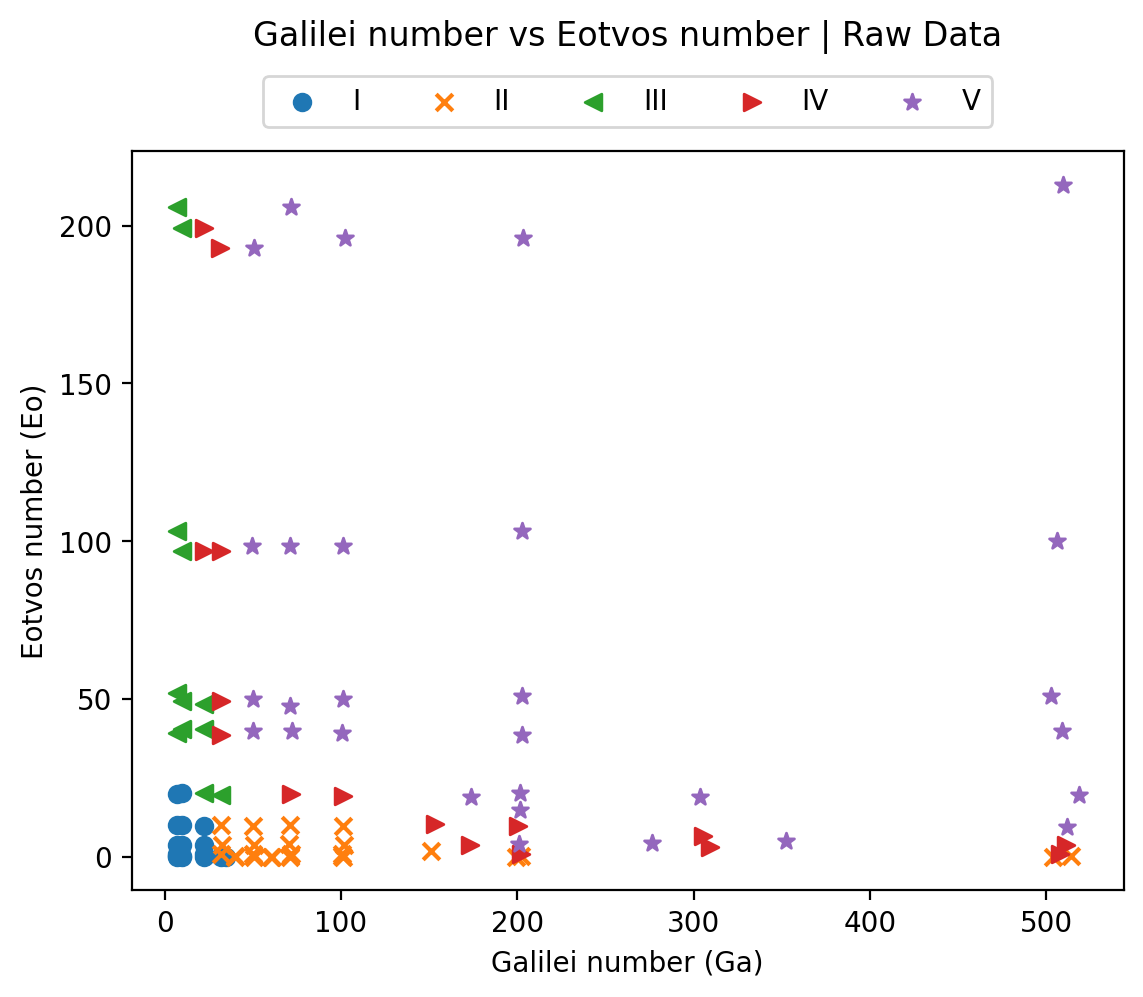

In [66]:
markers = ["o", "x", "<", ">", "*"]
for regime, marker in zip(regimes, markers):
  plt.scatter(data[data["regime"]==regime]["Ga"], data[data["regime"]==regime]["Eo"], marker=marker, label=regime)
plt.title("Galilei number vs Eotvos number | Raw Data", y=1.12)
plt.xlabel("Galilei number (Ga)")
plt.ylabel("Eotvos number (Eo)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=5)
plt.savefig(f"{output_path}/00_raw_data_scatter.png", bbox_inches='tight')


Now we take the log of the Galilei and Eotvos numbers to better visualize the data. Then we normalize the data to be in the range of [-1, 1].

We will use the min-max-normalization formula:
$$
\text{ (1) } x_i^* = \frac{x_i - x_{\min}}{x_{\max} - x_{\min}},\ x_i^{*} \in [0, 1] 
$$

$$
\text{(2)}\quad \tilde{x}_i = 2x_i^* - 1,\quad \tilde{x}_i \in [-1,1]
$$


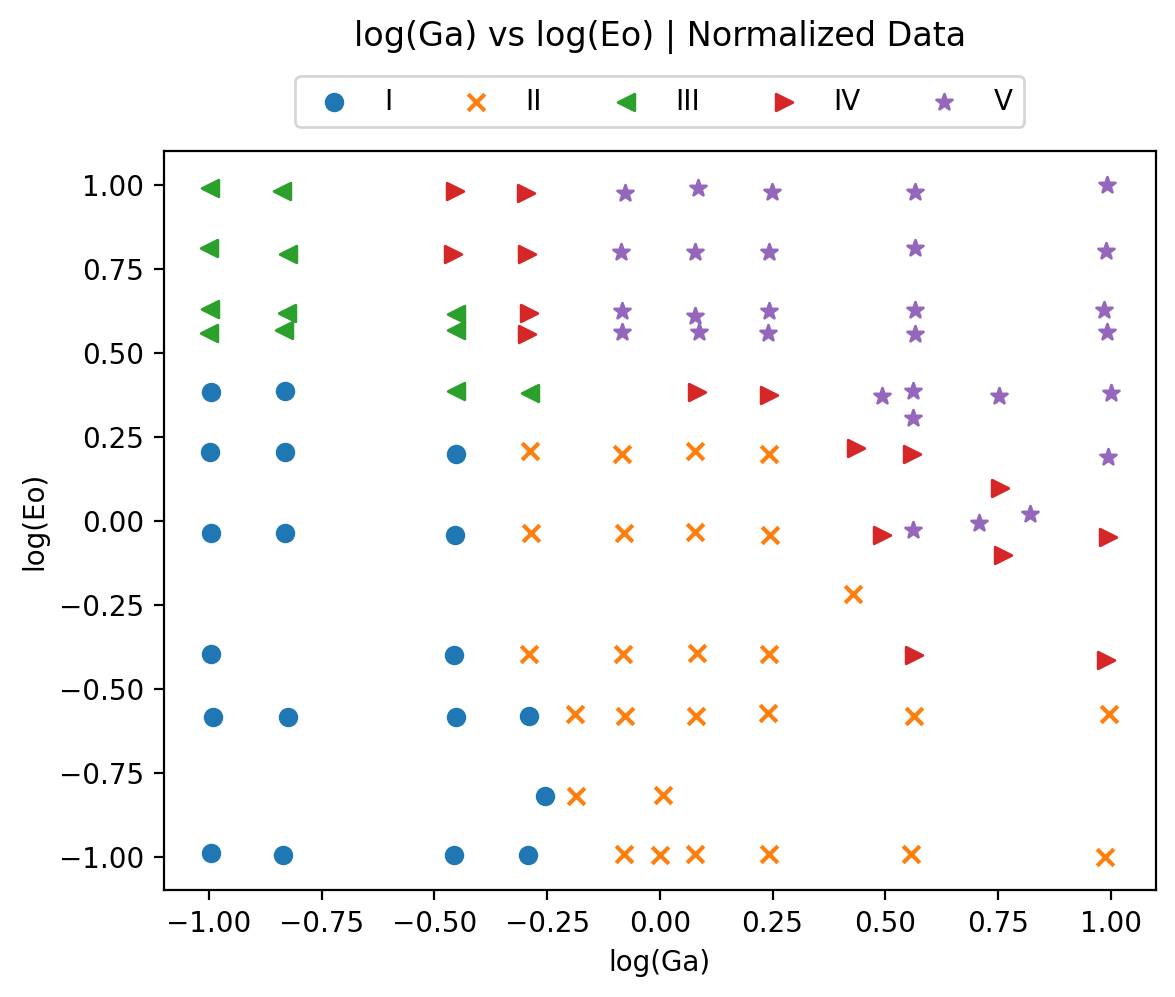

In [67]:
logData = data[["Ga", "Eo"]].apply(np.log10)
logData["regime"] = data["regime"].copy()
min_vals = logData[["Ga", "Eo"]].min()
max_vals = logData[["Ga", "Eo"]].max()
logData[["Ga", "Eo"]] = (logData[["Ga", "Eo"]] - min_vals)/(max_vals - min_vals)
logData[["Ga", "Eo"]] = 2 * logData[["Ga", "Eo"]] - 1

for regime, marker in zip(regimes, markers):
  plt.scatter(logData[logData["regime"]==regime]["Ga"], logData[logData["regime"]==regime]["Eo"], marker=marker, label=regime)
plt.title("log(Ga) vs log(Eo) | Normalized Data", y=1.12)
plt.xlabel("log(Ga)")
plt.ylabel("log(Eo)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=5)
plt.savefig(f"{output_path}/01_normalized_data_scatter.png", bbox_inches='tight')

## Binary Classification with Perceptron

In [ ]:
class Perceptron:
    """Implements perceptron algorithm and learning rule."""
    def __init__(self, n_weights: int):
        """Initialize perceptron instance.

        :param n_weights: number of free parameters; must be
            equal to the number of features
        :type n_weights: int
        """

        self._p = pt.rand(n_weights) * 2 - 1  # weights (w1,w2,b) initialized randomly in [-1, 1]

    def _loss(self, X: pt.Tensor, y: pt.Tensor) -> pt.Tensor:
        """Compute perceptron loss.

        :param y_hat: predicted labels
        :type y_hat: pt.Tensor
        :param y: target labels
        :type y: pt.Tensor
        :return: perceptron loss
        :rtype: pt.Tensor
        """
        y_hat = self.predict(X)
        return 0.5 * pt.sum((y - y_hat) ** 2)

    def _loss_gradient(self, X : pt.Tensor, y: pt.Tensor) -> pt.Tensor:
        y_hat = self.predict(X)
        delta = y - y_hat # (yi - y_hat_i)
        feature_vector = X # x = (Ga, Eo, 1)^T
        return -(delta @ feature_vector)  # sum_i (yi - y_hat_i) * xi

    def predict(self, X: pt.Tensor) -> pt.Tensor:
        """Predict labels for given input features.

        :param X: input features
        :type X: pt.Tensor
        """
        linear_output = X @ self._p  # linear output: w1*x1 + w2*x2 + b
        return pt.heaviside(linear_output, pt.tensor(0.0))

    def train(self, X: pt.Tensor, y: pt.Tensor, learning_rate=0.01, epochs=100, tol=1e-4):
        """Train perceptron using perceptron learning rule."""

        loss = []
        for epoch in range(epochs):
            self._p = self._p - learning_rate * self._loss_gradient(X, y)
            loss.append(self._loss(X, y).item())
            if loss[-1] < tol:
                print(f"Converged after epochs {epoch+1}")
                return loss
        print(f"Did not converge within {epochs} epochs")
        print(f"Final loss: {loss[-1]:.4f}")
        return loss

In [ ]:
reg_1_2 = (logData["regime"] == "I") | (logData["regime"] == "II") # Select regimes I and II
features = pt.tensor(logData[reg_1_2][["Ga", "Eo"]].values, dtype=pt.float32)
logData["label"] = 0.0
for i, regime in enumerate(regimes):
    logData.label.mask(logData["regime"] == regime, i, inplace=True)
labels = pt.tensor(logData.label[reg_1_2].values, dtype=pt.float32)

/tmp/ipykernel_26008/811071407.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  logData.label.mask(logData["regime"] == regime, i, inplace=True)
/tmp/ipykernel_26008/811071407.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [70]:
perceptron_model = Perceptron(n_weights=3)  # 2 features + bias
loss = perceptron_model.train(X_train, y_train, learning_rate=0.01, epochs=1000, tol=1e-4)

NameError: name 'X_train' is not defined